In [2]:
library(lpirfs)
library(gridExtra)
library(ggplot2)
library(readxl)
library(httr)

library(reshape2)
library(purrr) 

In [ ]:
run_lp_model <- function(data, endog, exog, max_lags, newey_lags = NULL, horizons = 10, signif, lags_exog = NULL) {
  # Map confidence levels to the corresponding values
  confint_map <- c("0.05" = 1.96, "0.32" = 1)
  
  # Check if the provided significance level is valid
  if (!as.character(signif) %in% names(confint_map)) {
    stop("Invalid significance level. Use 0.05 for 95% or 0.32 for 68%.")
  }

  if (!is.null(exog)) {
    exog_data <- data[, exog, drop = FALSE]
    if (is.null(lags_exog)) {
        lags_exog = max_lags
    }
  } else {
    exog_data = NULL
  }
  
  # Select endogenous variables
  endog_data <- data[, endog, drop = FALSE]
  
  # Convert to numeric (ensure proper model fitting)
  endog_data <- data.frame(lapply(endog_data, as.numeric))
  
  # Run the local projections model
  results_lin <- lp_lin(
    endog_data, 
    exog_data = exog_data,
    lags_endog_lin = max_lags,  
    trend          = 0,  
    shock_type     = 1,  
    confint        = confint_map[as.character(signif)], 
    nw_lag         = newey_lags,
    hor            = horizons,
    lags_exog = lags_exog
  )

  title_text <- paste0(
    "LocalProjection ", 
    if (!is.null(exog)) "(with exog)" else "(without exog)", 
    " - signif ", 1-signif
  )

  print(title_text)
  pretty_results(results_lin, endog)

  # Generate and return plots
  linear_plots <- plot_lin(results_lin)
  
  # Show all plots
  lin_plots_all <- sapply(linear_plots, ggplotGrob)s

  final_plot <- marrangeGrob(lin_plots_all, nrow = length(endog), ncol = length(endog), top = grid::textGrob(title_text, gp = grid::gpar(fontsize = 14, fontface = "bold")))

  grid::grid.draw(final_plot)
}

melt_irf_data <- function(irf_array, value_name, endog_vars) {
  # Melt the irf_array and ensure it has all the necessary columns
  df <- melt(irf_array)
  colnames(df) <- c("Horizon", "Shock_Index", "Response_Index", value_name)

  # Map the numeric indices to the actual variable names
  df$Shock_Variable <- endog_vars[df$Shock_Index]
  df$Response_Variable <- endog_vars[df$Response_Index]

  # Keep only meaningful columns (with value_name handled properly)
  df <- df %>% dplyr::select(all_of(c("Horizon", "Shock_Variable", "Response_Variable", value_name)))

  # Ensure no NA values are dropped prematurely by keeping rows with missing data
  return(df)
}


pretty_results <- function(results_lin, endog_vars) {
  # Melt IRF mean, lower bound, and upper bound
  irf_mean_df <- melt_irf_data(results_lin$irf_lin_mean, "IRF_Value", endog_vars)
  irf_low_df  <- melt_irf_data(results_lin$irf_lin_low, "Lower_Bound", endog_vars)
  irf_up_df   <- melt_irf_data(results_lin$irf_lin_up, "Upper_Bound", endog_vars)

  # Merge all three dataframes by matching Horizon, Shock_Variable, and Response_Variable
  irf_df <- reduce(list(irf_mean_df, irf_low_df, irf_up_df), dplyr::full_join, 
                   by = c("Horizon", "Shock_Variable", "Response_Variable"))

  # Arrange for readability
  irf_df <- irf_df %>% dplyr::arrange(Horizon, Shock_Variable, Response_Variable)

  # Print a sample
  print(head(irf_df, 10))  # Show first 10 rows for verification

  return(irf_df)  # Return the structured dataframe
}

In [7]:
# Example of how to call the function
url <- "https://github.com/mbarrena/tesis/raw/refs/heads/main/data/Data%20trimestral%201950%20a%202023%20con%20DUMMIES%20outliers%20(por%20trimestre).xlsx"
temp_file <- tempfile(fileext = ".xlsx")
GET(url, write_disk(temp_file, overwrite = TRUE))

# Read the `data` from the Excel file
data <- read_excel(temp_file)

Response [https://raw.githubusercontent.com/mbarrena/tesis/refs/heads/main/data/Data%20trimestral%201950%20a%202023%20con%20DUMMIES%20outliers%20(por%20trimestre).xlsx]
  Date: 2025-03-23 15:01
  Status: 200
  Content-Type: application/octet-stream
  Size: 57.9 kB
<ON DISK>  /var/folders/59/6k0yx0n916gg1mdb04zs42rm0000gn/T//Rtmpf96FNu/file5300638aefd6.xlsxNULL

[1] "LocalProjection (with exog) - signif 0.95"
   Horizon Shock_Variable Response_Variable     IRF_Value   Lower_Bound
1        1              E                 E  1.000000e+00  1.000000e+00
2        1              E         ipc_ajust  0.000000e+00  0.000000e+00
3        1              E             pbird  0.000000e+00  0.000000e+00
4        1      ipc_ajust                 E  3.097182e+00  2.312238e+00
5        1      ipc_ajust         ipc_ajust  3.161742e-02  2.000248e-02
6        1      ipc_ajust             pbird -5.881405e-06 -2.050847e-05
7        1          pbird                 E  4.026137e+00  1.954291e+00
8        1          pbird         ipc_ajust  8.353809e-02  4.967236e-02
9        1          pbird             pbird -3.602478e-05 -9.361867e-05
10       1           <NA>                 E  6.440008e-01 -2.340565e+00
    Upper_Bound
1  1.000000e+00
2  0.000000e+00
3  0.000000e+00
4  3.882126e+00
5  4.323237e-02
6  8.745659e-06
7  6.097982e+00
8  1.174038e-01
9  2.156911e-05


[[1]]
NULL

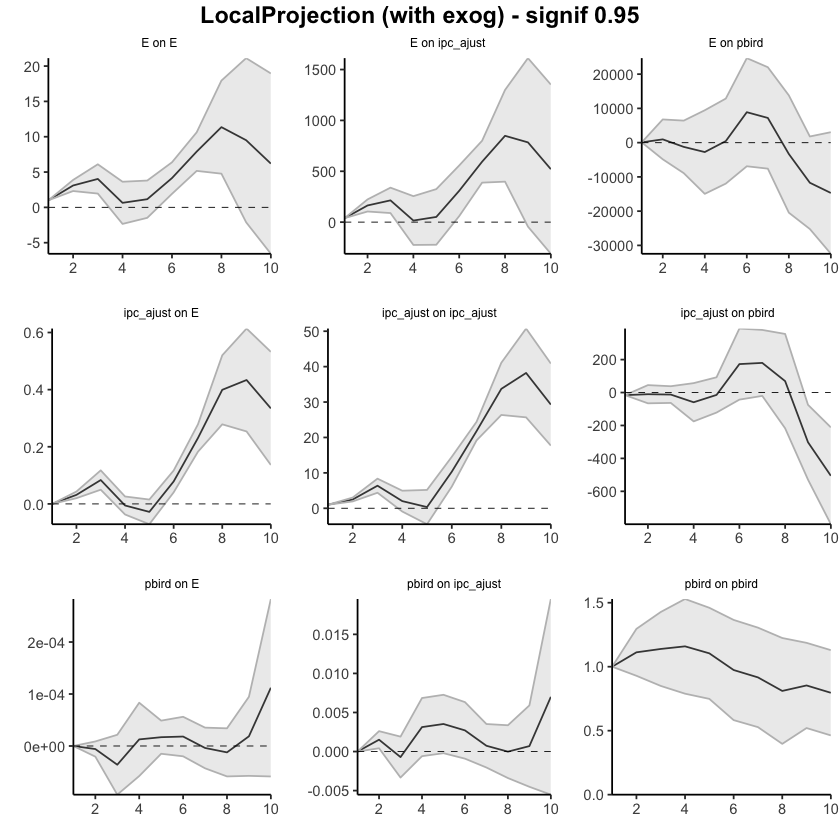

In [5]:
run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, newey_lags = 4, signif = 0.05)
#run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, newey_lags = 4, signif = 0.32)
#run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, signif = 0.05)
#run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, signif = 0.32)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, newey_lags = 4, signif = 0.05)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, newey_lags = 4, signif = 0.32)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, signif = 0.05)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, signif = 0.32)